In [1]:
import numpy as np
import os
import pandas as pd
from oncotree_ext import OncoNode,OncoTree
from IPython.display import Image
from util import calc_pair_mat, plot_df, s_softmax
import json
from copy import deepcopy
from scipy.special import logsumexp
import time

In [2]:
cancer_type = 'LUSC'
weights_dir = 'data/tracerx/raw/%s/%s_weights'%(cancer_type, cancer_type)
clones_dir = 'data/tracerx/raw/%s/%s_clones'%(cancer_type, cancer_type)
patient_ids = [item.split('.')[0] for item in os.listdir(clones_dir) if item.endswith('.csv')]
patient_ids.sort()

In [3]:
output_file = 'data/tracerx/%s.json'%cancer_type

In [4]:
dataset_dic = {}
weights_dic = {}
for patient_id in patient_ids:
    dataset_dic[patient_id] = np.array(pd.read_csv(os.path.join(clones_dir, patient_id)+'.csv'), dtype=int)
    weights_dic[patient_id] = np.array(pd.read_csv(os.path.join(weights_dir, patient_id)+'.csv')).reshape(-1)
gene_names = list(pd.read_csv(os.path.join(clones_dir, patient_ids[0])+'.csv').columns)

In [5]:
for key in weights_dic.keys():
    if 1 in weights_dic[key]:
        _idx = list(weights_dic[key]).index(1)
        weights_dic[key] = np.array([1.])
        dataset_dic[key] = dataset_dic[key][_idx,:].reshape(1,-1)

In [6]:
dataset = np.concatenate([dataset_dic[key] for key in dataset_dic.keys()])
frames = [weights_dic[key] for key in weights_dic.keys()]
weights = np.concatenate(frames, axis=0)
n_muts = []
for gene in range(dataset.shape[1]):
    n_muts.append(np.sum(weights[dataset[:, gene] == 1]))
n_muts = np.array(n_muts)

In [7]:
threshold = len(patient_ids)/1000
genes_to_keep = n_muts>threshold

In [8]:
for patient_id in patient_ids:
    dataset_dic[patient_id] = dataset_dic[patient_id][:, genes_to_keep]
gene_names = [item for i, item in enumerate(gene_names) if genes_to_keep[i]]

In [9]:
json_dataset = {
    'clones': {key:dataset_dic[key].astype(int).tolist() for key in dataset_dic.keys()},
    'weights': {key:weights_dic[key].reshape(-1).tolist() for key in weights_dic.keys()},
    'gene_names': gene_names
    }
with open(output_file, 'w') as f:
     f.write(json.dumps(json_dataset, indent=2))

# Done with the preprocessing

In [10]:
input_file = output_file

if input_file.endswith('.csv'):
    df_input = pd.read_csv(input_file, delimiter=',', index_col=None, comment='#')
    if df_input.iloc[0,0] not in [0,1]:
        # The csv does have index column
        # RELOADING
        df_input = pd.read_csv(input_file, delimiter=',', index_col=0, comment='#')
    dataset_dic = {idx: np.array(df_input.loc[idx,:]).reshape(1,-1).astype(bool) for idx in df_input.index}
    weights_dic = {idx: np.array([[1.]]) for idx in df_input.index}
    gene_names = list(df_input.columns)
    print('CSV input successfully loaded\n')
else:
    with open(input_file, 'r') as f:
        json_dataset = json.load(f)
    dataset_dic = {
        key: np.array(json_dataset['clones'][key]).astype(bool)
        for key in json_dataset['clones'].keys()
    }
    weights_dic = {
        key: np.array(json_dataset['weights'][key]).reshape(-1,1)
        for key in json_dataset['weights'].keys()
    }
    gene_names = list(json_dataset['gene_names'])
    print('JSON input successfully loaded\n')

JSON input successfully loaded



# Done with loading the json file

In [11]:
dataset=np.concatenate([dataset_dic[key] for key in dataset_dic.keys()])
MI_scores,MI_log_pvalues, ME_log_pvalues = calc_pair_mat(dataset)

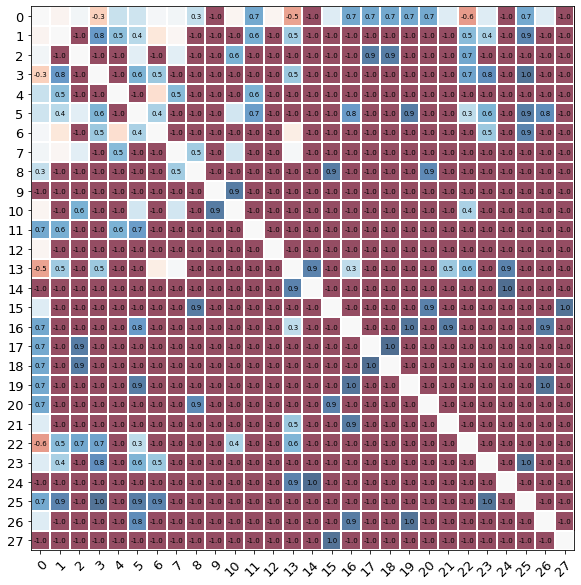

In [12]:
fig = plot_df(pd.DataFrame(MI_scores), vmin=-1, vmax=1, fontsize=7, good_to_print=lambda x: np.abs(x)>0.3)

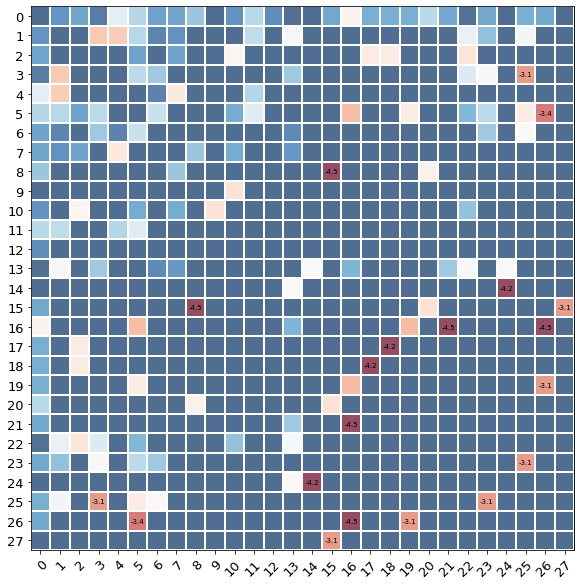

In [13]:
fig = plot_df(pd.DataFrame(MI_log_pvalues), vmin=-4, vmax=0, fontsize=7, good_to_print=lambda x: x<-3)

In [14]:
sample = OncoTree.star_from_dataset(dataset_dic,weights_dic)

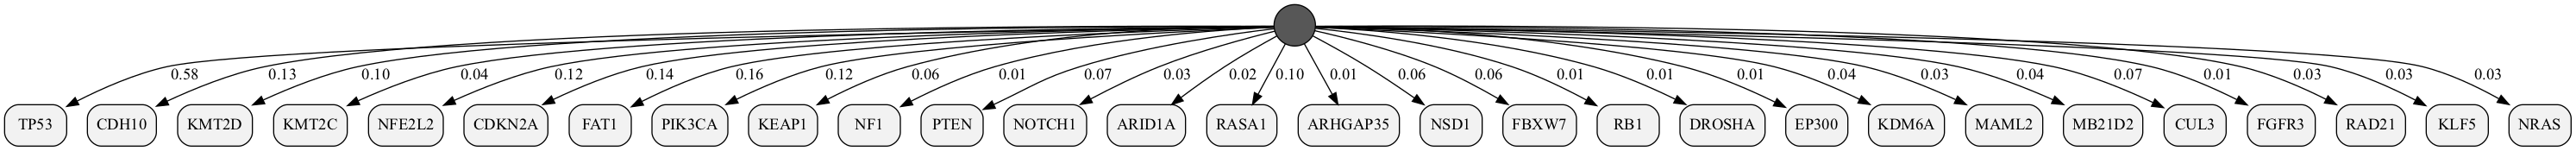

In [15]:
sample.to_dot(dataset_dic, weights_dic, gene_names=gene_names)
Image('tmp.png')

In [16]:
for i, v in enumerate(sample.mut_rates/len(dataset_dic)):
    print('%s: %.4f'%(gene_names[i],v*100))

TP53: 58.0511
CDH10: 13.0083
KMT2D: 9.7543
KMT2C: 4.3093
NFE2L2: 12.1291
CDKN2A: 14.2101
FAT1: 16.1128
PIK3CA: 12.2164
KEAP1: 6.2500
NF1: 0.1906
PTEN: 7.3667
NOTCH1: 3.3409
ARID1A: 1.8490
RASA1: 9.8210
ARHGAP35: 0.1868
NSD1: 5.7740
FBXW7: 5.5491
RB1: 0.5175
DROSHA: 0.5175
EP300: 0.8126
KDM6A: 3.6335
MAML2: 3.3747
MB21D2: 4.4490
CUL3: 7.0883
FGFR3: 0.1868
RAD21: 3.1250
KLF5: 3.1250
NRAS: 3.1250


In [17]:
sample.likelihood(dataset_dic, weights_dic)

-172.56315154124255

In [18]:
st = time.time()
sample, current_posterior, best_sample, best_posterior, posteriors_list, n_updates, details, scans_tensor = sample.fast_training_iteration(
dataset_dic, weights_dic, 100, 0
)
print(time.time()-st)

10.066179752349854


In [37]:
scans_mat2 = np.expand_dims(scans_mat,3)

In [36]:
scans_mat.reshape(scans)

(28, 28, 10)

In [41]:
scans_mat2[:,:,:,0] == scans_mat

True

In [60]:
scans_mat2=scans_mat2.reshape(28,28,10)

In [61]:
scans_mat2.shape

(28, 28, 10)

In [70]:
np.concatenate([np.expand_dims(scans_mat,3), np.expand_dims(scans_mat2,3)], axis=3).shape

(28, 28, 10, 2)

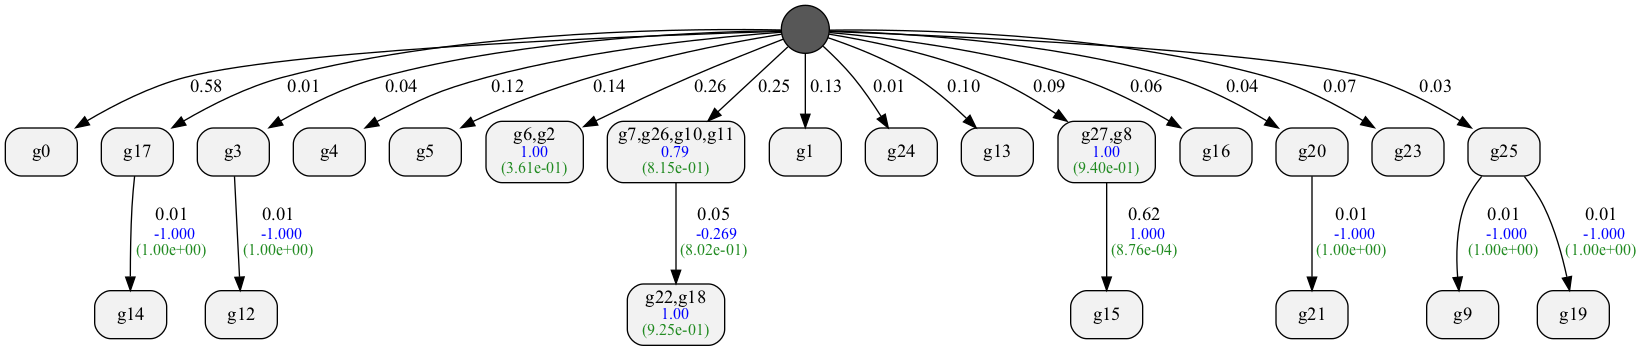

In [25]:
sample.to_dot(dataset_dic, weights_dic, gene_names=None)
Image('tmp.png')

In [ ]:
sample.likelihood(dataset_dic, weights_dic)

In [71]:
with open('result/tracerx/LUSC/scans.npy', 'rb') as f:
    scans_tensor = np.load(f)

In [76]:
scans_tensor.shape

(28, 28, 20, 3, 5)

In [83]:
post = scans_tensor[:,:, 10:, :, -1].mean(axis=3).mean(axis=2)

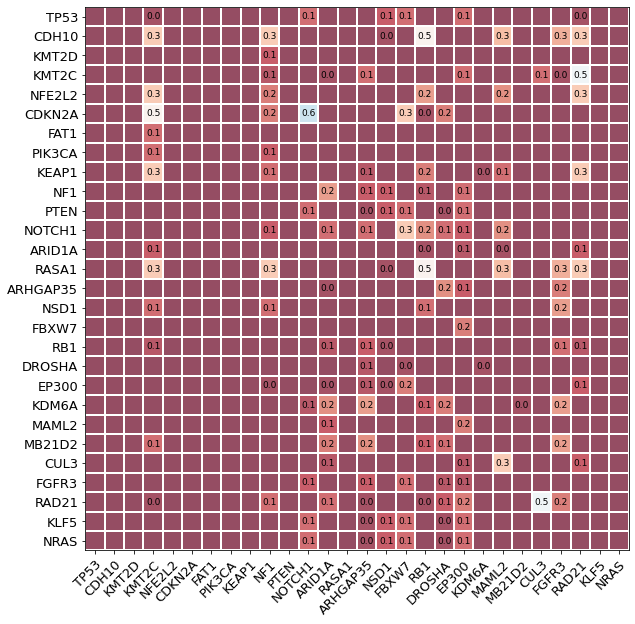

In [92]:
fig = plot_df(pd.DataFrame(post, columns=gene_names), vmin=0, vmax=1, fontsize=9, good_to_print=lambda x: x>0)

In [88]:
import pickle
with open('result/tracerx/LUSC/progmo.pkl', 'rb') as f:
    sample = pickle.load(f)

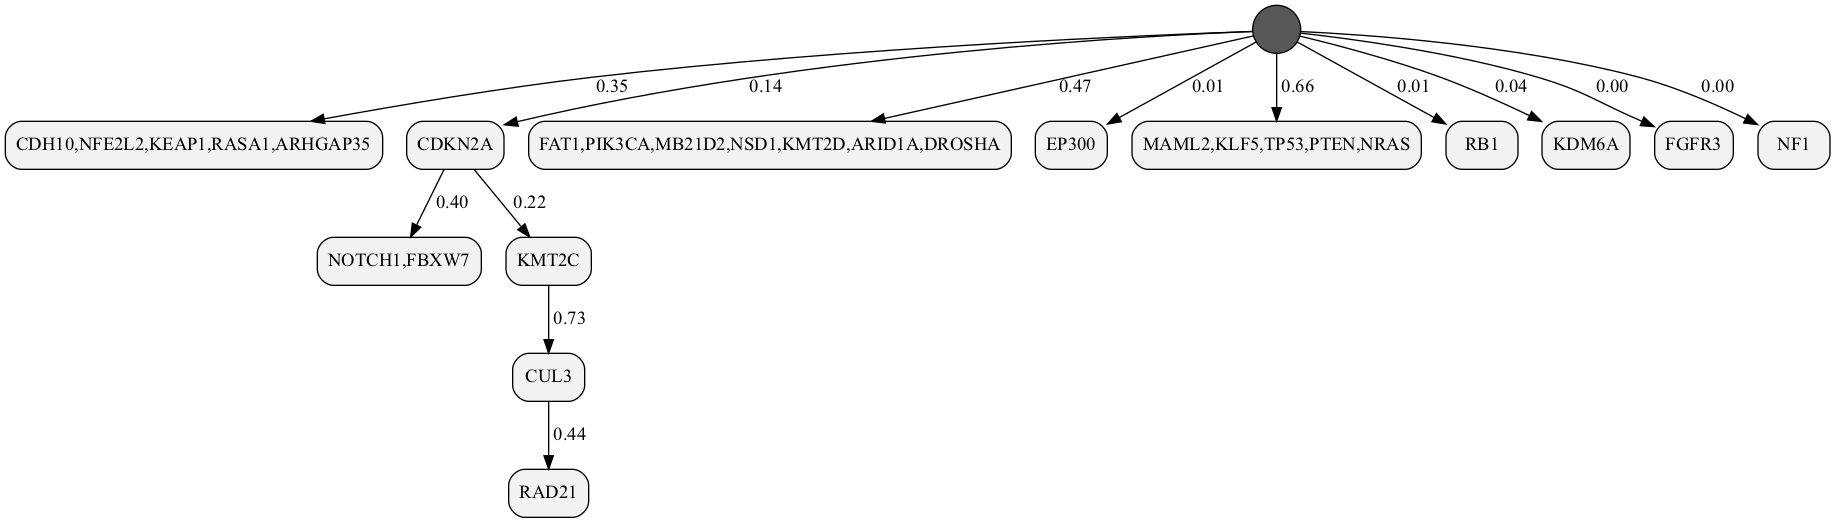

In [91]:
sample.to_dot(gene_names=gene_names)
Image('tmp.png')